<a href="https://colab.research.google.com/github/ostrichkim/colab/blob/main/assignment_dla_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 시작

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# copy folder
%cp -av /content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models /content/
%cp -av /content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/utils.py /content/

'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models' -> '/content/models'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/resnet.py' -> '/content/models/resnet.py'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/dla_simple.py' -> '/content/models/dla_simple.py'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/MobileNetV2.py' -> '/content/models/MobileNetV2.py'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/__init__.py' -> '/content/models/__init__.py'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/utils.py' -> '/content/utils.py'


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import random

from models import *
random.seed(1)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [5]:
img_size=150
learning_rate = 0.0001
epochs = 90
weight_decay = 5e-4
momentum = 0.9
batch_size = 64
num_workers = 2
num_classes = 20

In [6]:
# Normalize with mean and std
from torchvision.io import read_image
from torchvision import datasets

# trainset = datasets.ImageFolder('/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data',
#                  transform=transforms.ToTensor())
trainset = datasets.ImageFolder('/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data_200',
                 transform=transforms.ToTensor())
testset = datasets.ImageFolder('/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/test_data',
                 transform=transforms.ToTensor())

def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

train_mean, train_std = get_mean_and_std(trainset)
test_mean, test_std = get_mean_and_std(testset)
print(train_mean, train_std, '\n', test_mean, test_std)

==> Computing mean and std..


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


==> Computing mean and std..
tensor([0.5994, 0.5260, 0.4337]) tensor([0.2356, 0.2540, 0.2774]) 
 tensor([0.6083, 0.5351, 0.4456]) tensor([0.2308, 0.2525, 0.2799])


In [7]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90, expand=False),
    transforms.ColorJitter(brightness=(0.2, 3)),
    transforms.ToTensor(),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet standard
    transforms.Normalize(train_mean, train_std), # Customized mean and std    
])

transform_test = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet standard
    transforms.Normalize(test_mean, test_std), # Customized mean and std
])

# trainset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data', transform=transform_train)
trainset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data_200', transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/test_data', transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

==> Preparing data..


In [8]:
# Model
print('==> Building model..')
#net = MobileNetV2(num_classes)
#net = ResNet50(num_classes)
net = SimpleDLA(num_classes=num_classes)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

==> Building model..


In [9]:
# Adjust below codes if you want to train model continuously.
if False: 
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=epochs)

In [11]:
# Training
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx+1)%8==0:
            print("epoch : {}, Train iter : {} / {}, Loss : {:.4f}, Acc : {:.2f}% | {} / {}".format(
                epoch, 
                batch_idx+1, len(trainloader), 
                train_loss/(batch_idx+1), 
                100.*correct/total, correct, total))

    print("Train epoch : {}, Loss : {:.4f}, Acc : {:.2f}% | {} / {}".format(
        epoch, 
        train_loss/(batch_idx+1), 
        100.*correct/total, correct, total))
    train_loss_list.append(train_loss/(batch_idx+1))
    train_acc_list.append(100.*correct/total)

# Testing
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt_{}.pth'.format(epoch))
        best_acc = acc

    print("Test epoch : {}, Loss : {:.4f}, Acc : {:.2f}% | {} / {}".format(
        epoch,
        test_loss/(batch_idx+1), 
        100.*correct/total, correct, total))
    test_loss_list.append(test_loss/(batch_idx+1))
    test_acc_list.append(100.*correct/total)

In [12]:
for epoch in range(epochs):
    train(epoch)
    test(epoch)
    scheduler.step()

epoch : 0, Train iter : 8 / 63, Loss : 2.9390, Acc : 7.62% | 39 / 512
epoch : 0, Train iter : 16 / 63, Loss : 2.8652, Acc : 9.86% | 101 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 0, Train iter : 24 / 63, Loss : 2.8120, Acc : 11.59% | 178 / 1536
epoch : 0, Train iter : 32 / 63, Loss : 2.7656, Acc : 12.30% | 252 / 2048
epoch : 0, Train iter : 40 / 63, Loss : 2.7187, Acc : 14.45% | 370 / 2560
epoch : 0, Train iter : 48 / 63, Loss : 2.6892, Acc : 15.33% | 471 / 3072
epoch : 0, Train iter : 56 / 63, Loss : 2.6731, Acc : 15.74% | 564 / 3584
Train epoch : 0, Loss : 2.6453, Acc : 16.77% | 671 / 4000
Saving..
Test epoch : 0, Loss : 2.4874, Acc : 18.50% | 74 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 1, Train iter : 8 / 63, Loss : 2.5143, Acc : 18.55% | 95 / 512
epoch : 1, Train iter : 16 / 63, Loss : 2.4638, Acc : 21.19% | 217 / 1024
epoch : 1, Train iter : 24 / 63, Loss : 2.4408, Acc : 22.01% | 338 / 1536
epoch : 1, Train iter : 32 / 63, Loss : 2.4224, Acc : 23.05% | 472 / 2048


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 1, Train iter : 40 / 63, Loss : 2.4051, Acc : 23.59% | 604 / 2560
epoch : 1, Train iter : 48 / 63, Loss : 2.3995, Acc : 23.24% | 714 / 3072
epoch : 1, Train iter : 56 / 63, Loss : 2.3935, Acc : 23.88% | 856 / 3584
Train epoch : 1, Loss : 2.3920, Acc : 23.93% | 957 / 4000
Saving..
Test epoch : 1, Loss : 2.1874, Acc : 30.25% | 121 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 2, Train iter : 8 / 63, Loss : 2.2651, Acc : 28.71% | 147 / 512
epoch : 2, Train iter : 16 / 63, Loss : 2.2647, Acc : 28.52% | 292 / 1024
epoch : 2, Train iter : 24 / 63, Loss : 2.2387, Acc : 28.91% | 444 / 1536
epoch : 2, Train iter : 32 / 63, Loss : 2.2467, Acc : 28.22% | 578 / 2048
epoch : 2, Train iter : 40 / 63, Loss : 2.2421, Acc : 27.93% | 715 / 2560
epoch : 2, Train iter : 48 / 63, Loss : 2.2259, Acc : 28.97% | 890 / 3072
epoch : 2, Train iter : 56 / 63, Loss : 2.2209, Acc : 29.19% | 1046 / 3584
Train epoch : 2, Loss : 2.2075, Acc : 29.45% | 1178 / 4000
Saving..
Test epoch : 2, Loss : 2.0913, Acc : 32.75% | 131 / 400
epoch : 3, Train iter : 8 / 63, Loss : 2.1579, Acc : 33.20% | 170 / 512
epoch : 3, Train iter : 16 / 63, Loss : 2.1388, Acc : 31.45% | 322 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 3, Train iter : 24 / 63, Loss : 2.1225, Acc : 32.10% | 493 / 1536
epoch : 3, Train iter : 32 / 63, Loss : 2.1343, Acc : 32.23% | 660 / 2048


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 3, Train iter : 40 / 63, Loss : 2.1395, Acc : 32.62% | 835 / 2560
epoch : 3, Train iter : 48 / 63, Loss : 2.1370, Acc : 32.58% | 1001 / 3072
epoch : 3, Train iter : 56 / 63, Loss : 2.1267, Acc : 32.51% | 1165 / 3584
Train epoch : 3, Loss : 2.1271, Acc : 32.48% | 1299 / 4000
Test epoch : 3, Loss : 2.2530, Acc : 32.75% | 131 / 400
epoch : 4, Train iter : 8 / 63, Loss : 2.1388, Acc : 31.45% | 161 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 4, Train iter : 16 / 63, Loss : 2.1029, Acc : 32.81% | 336 / 1024
epoch : 4, Train iter : 24 / 63, Loss : 2.0591, Acc : 34.31% | 527 / 1536
epoch : 4, Train iter : 32 / 63, Loss : 2.0583, Acc : 34.42% | 705 / 2048
epoch : 4, Train iter : 40 / 63, Loss : 2.0685, Acc : 33.71% | 863 / 2560
epoch : 4, Train iter : 48 / 63, Loss : 2.0612, Acc : 33.79% | 1038 / 3072


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 4, Train iter : 56 / 63, Loss : 2.0507, Acc : 34.35% | 1231 / 3584
Train epoch : 4, Loss : 2.0535, Acc : 34.08% | 1363 / 4000
Test epoch : 4, Loss : 2.2690, Acc : 29.75% | 119 / 400
epoch : 5, Train iter : 8 / 63, Loss : 1.9571, Acc : 37.70% | 193 / 512
epoch : 5, Train iter : 16 / 63, Loss : 1.9538, Acc : 38.87% | 398 / 1024
epoch : 5, Train iter : 24 / 63, Loss : 1.9608, Acc : 38.22% | 587 / 1536
epoch : 5, Train iter : 32 / 63, Loss : 1.9418, Acc : 39.45% | 808 / 2048


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 5, Train iter : 40 / 63, Loss : 1.9319, Acc : 39.61% | 1014 / 2560
epoch : 5, Train iter : 48 / 63, Loss : 1.9476, Acc : 39.06% | 1200 / 3072
epoch : 5, Train iter : 56 / 63, Loss : 1.9459, Acc : 38.87% | 1393 / 3584
Train epoch : 5, Loss : 1.9415, Acc : 38.98% | 1559 / 4000
Saving..
Test epoch : 5, Loss : 1.9511, Acc : 36.75% | 147 / 400
epoch : 6, Train iter : 8 / 63, Loss : 1.8764, Acc : 39.06% | 200 / 512
epoch : 6, Train iter : 16 / 63, Loss : 1.9246, Acc : 38.48% | 394 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 6, Train iter : 24 / 63, Loss : 1.9037, Acc : 39.13% | 601 / 1536
epoch : 6, Train iter : 32 / 63, Loss : 1.8893, Acc : 39.65% | 812 / 2048
epoch : 6, Train iter : 40 / 63, Loss : 1.8687, Acc : 41.09% | 1052 / 2560
epoch : 6, Train iter : 48 / 63, Loss : 1.8583, Acc : 41.73% | 1282 / 3072
epoch : 6, Train iter : 56 / 63, Loss : 1.8447, Acc : 42.22% | 1513 / 3584
Train epoch : 6, Loss : 1.8440, Acc : 42.25% | 1690 / 4000
Test epoch : 6, Loss : 2.0990, Acc : 36.75% | 147 / 400
epoch : 7, Train iter : 8 / 63, Loss : 1.8586, Acc : 40.43% | 207 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 7, Train iter : 16 / 63, Loss : 1.8178, Acc : 41.99% | 430 / 1024
epoch : 7, Train iter : 24 / 63, Loss : 1.8273, Acc : 41.28% | 634 / 1536
epoch : 7, Train iter : 32 / 63, Loss : 1.8269, Acc : 42.04% | 861 / 2048
epoch : 7, Train iter : 40 / 63, Loss : 1.8301, Acc : 41.68% | 1067 / 2560
epoch : 7, Train iter : 48 / 63, Loss : 1.8139, Acc : 42.64% | 1310 / 3072
epoch : 7, Train iter : 56 / 63, Loss : 1.7910, Acc : 43.36% | 1554 / 3584
Train epoch : 7, Loss : 1.7900, Acc : 43.17% | 1727 / 4000
Saving..
Test epoch : 7, Loss : 1.7867, Acc : 45.25% | 181 / 400
epoch : 8, Train iter : 8 / 63, Loss : 1.7054, Acc : 45.12% | 231 / 512
epoch : 8, Train iter : 16 / 63, Loss : 1.6857, Acc : 47.36% | 485 / 1024
epoch : 8, Train iter : 24 / 63, Loss : 1.7093, Acc : 47.01% | 722 / 1536
epoch : 8, Train iter : 32 / 63, Loss : 1.7220, Acc : 46.44% | 951 / 2048


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 8, Train iter : 40 / 63, Loss : 1.7297, Acc : 45.35% | 1161 / 2560
epoch : 8, Train iter : 48 / 63, Loss : 1.7344, Acc : 45.08% | 1385 / 3072
epoch : 8, Train iter : 56 / 63, Loss : 1.7285, Acc : 45.45% | 1629 / 3584
Train epoch : 8, Loss : 1.7225, Acc : 45.98% | 1839 / 4000
Saving..
Test epoch : 8, Loss : 1.6888, Acc : 47.25% | 189 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 9, Train iter : 8 / 63, Loss : 1.6705, Acc : 47.27% | 242 / 512
epoch : 9, Train iter : 16 / 63, Loss : 1.6419, Acc : 47.75% | 489 / 1024
epoch : 9, Train iter : 24 / 63, Loss : 1.6452, Acc : 48.05% | 738 / 1536
epoch : 9, Train iter : 32 / 63, Loss : 1.6375, Acc : 47.71% | 977 / 2048
epoch : 9, Train iter : 40 / 63, Loss : 1.6460, Acc : 47.66% | 1220 / 2560


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 9, Train iter : 48 / 63, Loss : 1.6503, Acc : 47.85% | 1470 / 3072
epoch : 9, Train iter : 56 / 63, Loss : 1.6504, Acc : 47.52% | 1703 / 3584
Train epoch : 9, Loss : 1.6534, Acc : 47.83% | 1913 / 4000
Saving..
Test epoch : 9, Loss : 1.7631, Acc : 48.75% | 195 / 400
epoch : 10, Train iter : 8 / 63, Loss : 1.6833, Acc : 50.00% | 256 / 512
epoch : 10, Train iter : 16 / 63, Loss : 1.6222, Acc : 50.00% | 512 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 10, Train iter : 24 / 63, Loss : 1.6004, Acc : 50.52% | 776 / 1536
epoch : 10, Train iter : 32 / 63, Loss : 1.5855, Acc : 50.68% | 1038 / 2048
epoch : 10, Train iter : 40 / 63, Loss : 1.5773, Acc : 51.41% | 1316 / 2560
epoch : 10, Train iter : 48 / 63, Loss : 1.5834, Acc : 51.01% | 1567 / 3072
epoch : 10, Train iter : 56 / 63, Loss : 1.5847, Acc : 50.64% | 1815 / 3584
Train epoch : 10, Loss : 1.5806, Acc : 50.75% | 2030 / 4000
Test epoch : 10, Loss : 1.6852, Acc : 46.75% | 187 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 11, Train iter : 8 / 63, Loss : 1.5303, Acc : 50.98% | 261 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 11, Train iter : 16 / 63, Loss : 1.5361, Acc : 51.27% | 525 / 1024
epoch : 11, Train iter : 24 / 63, Loss : 1.5410, Acc : 51.17% | 786 / 1536
epoch : 11, Train iter : 32 / 63, Loss : 1.5305, Acc : 52.00% | 1065 / 2048
epoch : 11, Train iter : 40 / 63, Loss : 1.5310, Acc : 51.72% | 1324 / 2560
epoch : 11, Train iter : 48 / 63, Loss : 1.5413, Acc : 51.33% | 1577 / 3072
epoch : 11, Train iter : 56 / 63, Loss : 1.5490, Acc : 51.09% | 1831 / 3584
Train epoch : 11, Loss : 1.5500, Acc : 51.48% | 2059 / 4000
Saving..
Test epoch : 11, Loss : 1.6304, Acc : 53.00% | 212 / 400
epoch : 12, Train iter : 8 / 63, Loss : 1.5669, Acc : 49.61% | 254 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 12, Train iter : 16 / 63, Loss : 1.5387, Acc : 50.78% | 520 / 1024
epoch : 12, Train iter : 24 / 63, Loss : 1.5313, Acc : 50.52% | 776 / 1536
epoch : 12, Train iter : 32 / 63, Loss : 1.5157, Acc : 51.56% | 1056 / 2048
epoch : 12, Train iter : 40 / 63, Loss : 1.5263, Acc : 51.64% | 1322 / 2560
epoch : 12, Train iter : 48 / 63, Loss : 1.5193, Acc : 51.99% | 1597 / 3072
epoch : 12, Train iter : 56 / 63, Loss : 1.5062, Acc : 52.43% | 1879 / 3584
Train epoch : 12, Loss : 1.5097, Acc : 51.95% | 2078 / 4000
Test epoch : 12, Loss : 1.6798, Acc : 47.50% | 190 / 400
epoch : 13, Train iter : 8 / 63, Loss : 1.4343, Acc : 53.12% | 272 / 512
epoch : 13, Train iter : 16 / 63, Loss : 1.4513, Acc : 52.64% | 539 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 13, Train iter : 24 / 63, Loss : 1.4791, Acc : 52.15% | 801 / 1536
epoch : 13, Train iter : 32 / 63, Loss : 1.4938, Acc : 52.05% | 1066 / 2048
epoch : 13, Train iter : 40 / 63, Loss : 1.4919, Acc : 51.88% | 1328 / 2560
epoch : 13, Train iter : 48 / 63, Loss : 1.4788, Acc : 52.67% | 1618 / 3072
epoch : 13, Train iter : 56 / 63, Loss : 1.4627, Acc : 53.12% | 1904 / 3584
Train epoch : 13, Loss : 1.4584, Acc : 53.52% | 2141 / 4000
Test epoch : 13, Loss : 1.5740, Acc : 50.75% | 203 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 14, Train iter : 8 / 63, Loss : 1.3511, Acc : 57.81% | 296 / 512
epoch : 14, Train iter : 16 / 63, Loss : 1.3942, Acc : 55.47% | 568 / 1024
epoch : 14, Train iter : 24 / 63, Loss : 1.3997, Acc : 55.21% | 848 / 1536
epoch : 14, Train iter : 32 / 63, Loss : 1.4102, Acc : 55.18% | 1130 / 2048
epoch : 14, Train iter : 40 / 63, Loss : 1.4190, Acc : 55.31% | 1416 / 2560
epoch : 14, Train iter : 48 / 63, Loss : 1.4166, Acc : 55.37% | 1701 / 3072
epoch : 14, Train iter : 56 / 63, Loss : 1.4128, Acc : 55.89% | 2003 / 3584
Train epoch : 14, Loss : 1.4089, Acc : 55.83% | 2233 / 4000
Saving..
Test epoch : 14, Loss : 1.4365, Acc : 55.25% | 221 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 15, Train iter : 8 / 63, Loss : 1.4120, Acc : 52.73% | 270 / 512
epoch : 15, Train iter : 16 / 63, Loss : 1.3894, Acc : 55.08% | 564 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 15, Train iter : 24 / 63, Loss : 1.3471, Acc : 56.38% | 866 / 1536
epoch : 15, Train iter : 32 / 63, Loss : 1.3434, Acc : 56.35% | 1154 / 2048
epoch : 15, Train iter : 40 / 63, Loss : 1.3665, Acc : 55.74% | 1427 / 2560
epoch : 15, Train iter : 48 / 63, Loss : 1.3755, Acc : 56.05% | 1722 / 3072
epoch : 15, Train iter : 56 / 63, Loss : 1.3737, Acc : 55.92% | 2004 / 3584
Train epoch : 15, Loss : 1.3710, Acc : 55.90% | 2236 / 4000
Test epoch : 15, Loss : 1.7197, Acc : 51.50% | 206 / 400
epoch : 16, Train iter : 8 / 63, Loss : 1.3276, Acc : 57.62% | 295 / 512
epoch : 16, Train iter : 16 / 63, Loss : 1.3591, Acc : 56.35% | 577 / 1024
epoch : 16, Train iter : 24 / 63, Loss : 1.3424, Acc : 56.51% | 868 / 1536


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 16, Train iter : 32 / 63, Loss : 1.3602, Acc : 56.30% | 1153 / 2048
epoch : 16, Train iter : 40 / 63, Loss : 1.3568, Acc : 56.37% | 1443 / 2560
epoch : 16, Train iter : 48 / 63, Loss : 1.3424, Acc : 56.51% | 1736 / 3072


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 16, Train iter : 56 / 63, Loss : 1.3428, Acc : 56.67% | 2031 / 3584
Train epoch : 16, Loss : 1.3426, Acc : 56.75% | 2270 / 4000
Test epoch : 16, Loss : 1.4791, Acc : 53.25% | 213 / 400
epoch : 17, Train iter : 8 / 63, Loss : 1.3863, Acc : 57.03% | 292 / 512
epoch : 17, Train iter : 16 / 63, Loss : 1.3001, Acc : 59.38% | 608 / 1024
epoch : 17, Train iter : 24 / 63, Loss : 1.2916, Acc : 59.96% | 921 / 1536
epoch : 17, Train iter : 32 / 63, Loss : 1.2969, Acc : 59.38% | 1216 / 2048
epoch : 17, Train iter : 40 / 63, Loss : 1.2962, Acc : 59.61% | 1526 / 2560
epoch : 17, Train iter : 48 / 63, Loss : 1.2878, Acc : 59.64% | 1832 / 3072


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 17, Train iter : 56 / 63, Loss : 1.2784, Acc : 59.99% | 2150 / 3584


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Train epoch : 17, Loss : 1.2927, Acc : 59.35% | 2374 / 4000
Test epoch : 17, Loss : 1.7014, Acc : 55.25% | 221 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 18, Train iter : 8 / 63, Loss : 1.3326, Acc : 57.42% | 294 / 512
epoch : 18, Train iter : 16 / 63, Loss : 1.3272, Acc : 58.01% | 594 / 1024
epoch : 18, Train iter : 24 / 63, Loss : 1.3040, Acc : 57.62% | 885 / 1536
epoch : 18, Train iter : 32 / 63, Loss : 1.2760, Acc : 58.45% | 1197 / 2048
epoch : 18, Train iter : 40 / 63, Loss : 1.2598, Acc : 58.75% | 1504 / 2560
epoch : 18, Train iter : 48 / 63, Loss : 1.2587, Acc : 58.85% | 1808 / 3072
epoch : 18, Train iter : 56 / 63, Loss : 1.2618, Acc : 59.21% | 2122 / 3584
Train epoch : 18, Loss : 1.2639, Acc : 59.12% | 2365 / 4000
Test epoch : 18, Loss : 1.8395, Acc : 50.25% | 201 / 400
epoch : 19, Train iter : 8 / 63, Loss : 1.1999, Acc : 64.26% | 329 / 512
epoch : 19, Train iter : 16 / 63, Loss : 1.2087, Acc : 62.60% | 641 / 1024
epoch : 19, Train iter : 24 / 63, Loss : 1.2119, Acc : 62.11% | 954 / 1536


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 19, Train iter : 32 / 63, Loss : 1.2517, Acc : 60.11% | 1231 / 2048
epoch : 19, Train iter : 40 / 63, Loss : 1.2445, Acc : 60.20% | 1541 / 2560
epoch : 19, Train iter : 48 / 63, Loss : 1.2410, Acc : 60.58% | 1861 / 3072
epoch : 19, Train iter : 56 / 63, Loss : 1.2340, Acc : 60.71% | 2176 / 3584
Train epoch : 19, Loss : 1.2285, Acc : 60.77% | 2431 / 4000
Saving..
Test epoch : 19, Loss : 1.2954, Acc : 57.75% | 231 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 20, Train iter : 8 / 63, Loss : 1.2594, Acc : 59.96% | 307 / 512
epoch : 20, Train iter : 16 / 63, Loss : 1.2296, Acc : 61.52% | 630 / 1024
epoch : 20, Train iter : 24 / 63, Loss : 1.2506, Acc : 60.74% | 933 / 1536
epoch : 20, Train iter : 32 / 63, Loss : 1.2300, Acc : 61.13% | 1252 / 2048
epoch : 20, Train iter : 40 / 63, Loss : 1.2203, Acc : 61.56% | 1576 / 2560
epoch : 20, Train iter : 48 / 63, Loss : 1.2081, Acc : 61.88% | 1901 / 3072


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 20, Train iter : 56 / 63, Loss : 1.2040, Acc : 62.05% | 2224 / 3584
Train epoch : 20, Loss : 1.1916, Acc : 62.27% | 2491 / 4000
Test epoch : 20, Loss : 1.4138, Acc : 57.75% | 231 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 21, Train iter : 8 / 63, Loss : 1.1429, Acc : 63.28% | 324 / 512
epoch : 21, Train iter : 16 / 63, Loss : 1.1705, Acc : 62.21% | 637 / 1024
epoch : 21, Train iter : 24 / 63, Loss : 1.1793, Acc : 61.52% | 945 / 1536
epoch : 21, Train iter : 32 / 63, Loss : 1.1751, Acc : 61.87% | 1267 / 2048
epoch : 21, Train iter : 40 / 63, Loss : 1.1721, Acc : 62.30% | 1595 / 2560
epoch : 21, Train iter : 48 / 63, Loss : 1.1647, Acc : 62.76% | 1928 / 3072
epoch : 21, Train iter : 56 / 63, Loss : 1.1594, Acc : 63.03% | 2259 / 3584
Train epoch : 21, Loss : 1.1635, Acc : 63.05% | 2522 / 4000
Test epoch : 21, Loss : 1.4513, Acc : 53.50% | 214 / 400
epoch : 22, Train iter : 8 / 63, Loss : 1.1355, Acc : 62.89% | 322 / 512
epoch : 22, Train iter : 16 / 63, Loss : 1.1197, Acc : 64.36% | 659 / 1024
epoch : 22, Train iter : 24 / 63, Loss : 1.1386, Acc : 63.54% | 976 / 1536
epoch : 22, Train iter : 32 / 63, Loss : 1.1260, Acc : 64.45% | 1320 / 2048


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 22, Train iter : 40 / 63, Loss : 1.1172, Acc : 64.41% | 1649 / 2560
epoch : 22, Train iter : 48 / 63, Loss : 1.1224, Acc : 64.23% | 1973 / 3072


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 22, Train iter : 56 / 63, Loss : 1.1167, Acc : 64.59% | 2315 / 3584
Train epoch : 22, Loss : 1.1111, Acc : 64.70% | 2588 / 4000
Saving..
Test epoch : 22, Loss : 1.3619, Acc : 59.00% | 236 / 400
epoch : 23, Train iter : 8 / 63, Loss : 1.0974, Acc : 66.02% | 338 / 512
epoch : 23, Train iter : 16 / 63, Loss : 1.0795, Acc : 66.41% | 680 / 1024
epoch : 23, Train iter : 24 / 63, Loss : 1.0739, Acc : 65.89% | 1012 / 1536


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 23, Train iter : 32 / 63, Loss : 1.0756, Acc : 66.02% | 1352 / 2048
epoch : 23, Train iter : 40 / 63, Loss : 1.0726, Acc : 66.09% | 1692 / 2560
epoch : 23, Train iter : 48 / 63, Loss : 1.0814, Acc : 66.08% | 2030 / 3072


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 23, Train iter : 56 / 63, Loss : 1.0732, Acc : 66.49% | 2383 / 3584
Train epoch : 23, Loss : 1.0684, Acc : 66.22% | 2649 / 4000
Test epoch : 23, Loss : 1.2960, Acc : 58.50% | 234 / 400
epoch : 24, Train iter : 8 / 63, Loss : 1.1435, Acc : 60.16% | 308 / 512
epoch : 24, Train iter : 16 / 63, Loss : 1.0936, Acc : 63.38% | 649 / 1024
epoch : 24, Train iter : 24 / 63, Loss : 1.0971, Acc : 64.00% | 983 / 1536
epoch : 24, Train iter : 32 / 63, Loss : 1.0618, Acc : 65.77% | 1347 / 2048


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 24, Train iter : 40 / 63, Loss : 1.0559, Acc : 65.59% | 1679 / 2560
epoch : 24, Train iter : 48 / 63, Loss : 1.0593, Acc : 65.62% | 2016 / 3072
epoch : 24, Train iter : 56 / 63, Loss : 1.0577, Acc : 65.57% | 2350 / 3584
Train epoch : 24, Loss : 1.0699, Acc : 65.33% | 2613 / 4000
Saving..
Test epoch : 24, Loss : 1.1475, Acc : 63.75% | 255 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 25, Train iter : 8 / 63, Loss : 1.0290, Acc : 68.36% | 350 / 512
epoch : 25, Train iter : 16 / 63, Loss : 1.0214, Acc : 67.97% | 696 / 1024
epoch : 25, Train iter : 24 / 63, Loss : 1.0261, Acc : 67.71% | 1040 / 1536


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 25, Train iter : 32 / 63, Loss : 1.0194, Acc : 67.97% | 1392 / 2048
epoch : 25, Train iter : 40 / 63, Loss : 1.0140, Acc : 67.93% | 1739 / 2560
epoch : 25, Train iter : 48 / 63, Loss : 1.0048, Acc : 68.20% | 2095 / 3072
epoch : 25, Train iter : 56 / 63, Loss : 1.0002, Acc : 68.44% | 2453 / 3584
Train epoch : 25, Loss : 1.0023, Acc : 68.22% | 2729 / 4000
Test epoch : 25, Loss : 1.2695, Acc : 60.00% | 240 / 400
epoch : 26, Train iter : 8 / 63, Loss : 0.9289, Acc : 71.48% | 366 / 512
epoch : 26, Train iter : 16 / 63, Loss : 0.9677, Acc : 68.46% | 701 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 26, Train iter : 24 / 63, Loss : 0.9962, Acc : 67.77% | 1041 / 1536
epoch : 26, Train iter : 32 / 63, Loss : 0.9980, Acc : 67.77% | 1388 / 2048
epoch : 26, Train iter : 40 / 63, Loss : 1.0008, Acc : 67.54% | 1729 / 2560
epoch : 26, Train iter : 48 / 63, Loss : 1.0014, Acc : 67.19% | 2064 / 3072
epoch : 26, Train iter : 56 / 63, Loss : 0.9996, Acc : 67.41% | 2416 / 3584
Train epoch : 26, Loss : 0.9948, Acc : 67.80% | 2712 / 4000
Test epoch : 26, Loss : 1.0850, Acc : 63.25% | 253 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 27, Train iter : 8 / 63, Loss : 0.9958, Acc : 70.90% | 363 / 512
epoch : 27, Train iter : 16 / 63, Loss : 0.9743, Acc : 71.00% | 727 / 1024
epoch : 27, Train iter : 24 / 63, Loss : 0.9377, Acc : 71.29% | 1095 / 1536
epoch : 27, Train iter : 32 / 63, Loss : 0.9470, Acc : 70.46% | 1443 / 2048
epoch : 27, Train iter : 40 / 63, Loss : 0.9418, Acc : 70.62% | 1808 / 2560
epoch : 27, Train iter : 48 / 63, Loss : 0.9535, Acc : 70.21% | 2157 / 3072
epoch : 27, Train iter : 56 / 63, Loss : 0.9517, Acc : 70.31% | 2520 / 3584
Train epoch : 27, Loss : 0.9507, Acc : 70.33% | 2813 / 4000
Saving..
Test epoch : 27, Loss : 1.0634, Acc : 69.25% | 277 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 28, Train iter : 8 / 63, Loss : 0.9025, Acc : 70.51% | 361 / 512
epoch : 28, Train iter : 16 / 63, Loss : 0.8991, Acc : 71.58% | 733 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 28, Train iter : 24 / 63, Loss : 0.8990, Acc : 71.42% | 1097 / 1536
epoch : 28, Train iter : 32 / 63, Loss : 0.9031, Acc : 71.24% | 1459 / 2048
epoch : 28, Train iter : 40 / 63, Loss : 0.9324, Acc : 70.08% | 1794 / 2560
epoch : 28, Train iter : 48 / 63, Loss : 0.9377, Acc : 70.35% | 2161 / 3072
epoch : 28, Train iter : 56 / 63, Loss : 0.9422, Acc : 69.95% | 2507 / 3584
Train epoch : 28, Loss : 0.9543, Acc : 69.47% | 2779 / 4000
Test epoch : 28, Loss : 1.3885, Acc : 54.75% | 219 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 29, Train iter : 8 / 63, Loss : 1.0209, Acc : 64.65% | 331 / 512
epoch : 29, Train iter : 16 / 63, Loss : 0.9362, Acc : 67.77% | 694 / 1024
epoch : 29, Train iter : 24 / 63, Loss : 0.9617, Acc : 67.97% | 1044 / 1536
epoch : 29, Train iter : 32 / 63, Loss : 0.9572, Acc : 67.92% | 1391 / 2048
epoch : 29, Train iter : 40 / 63, Loss : 0.9518, Acc : 68.48% | 1753 / 2560
epoch : 29, Train iter : 48 / 63, Loss : 0.9538, Acc : 68.62% | 2108 / 3072
epoch : 29, Train iter : 56 / 63, Loss : 0.9489, Acc : 68.95% | 2471 / 3584
Train epoch : 29, Loss : 0.9356, Acc : 69.45% | 2778 / 4000
Test epoch : 29, Loss : 1.2690, Acc : 60.00% | 240 / 400
epoch : 30, Train iter : 8 / 63, Loss : 0.8674, Acc : 72.27% | 370 / 512
epoch : 30, Train iter : 16 / 63, Loss : 0.8441, Acc : 71.68% | 734 / 1024
epoch : 30, Train iter : 24 / 63, Loss : 0.8692, Acc : 70.90% | 1089 / 1536
epoch : 30, Train iter : 32 / 63, Loss : 0.8722, Acc : 71.44% | 1463 / 2048


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 30, Train iter : 40 / 63, Loss : 0.8834, Acc : 71.41% | 1828 / 2560


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 30, Train iter : 48 / 63, Loss : 0.8841, Acc : 71.29% | 2190 / 3072
epoch : 30, Train iter : 56 / 63, Loss : 0.8850, Acc : 71.34% | 2557 / 3584
Train epoch : 30, Loss : 0.8868, Acc : 71.50% | 2860 / 4000
Test epoch : 30, Loss : 0.9459, Acc : 67.75% | 271 / 400
epoch : 31, Train iter : 8 / 63, Loss : 0.8447, Acc : 73.83% | 378 / 512
epoch : 31, Train iter : 16 / 63, Loss : 0.8324, Acc : 75.59% | 774 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 31, Train iter : 24 / 63, Loss : 0.8542, Acc : 74.41% | 1143 / 1536
epoch : 31, Train iter : 32 / 63, Loss : 0.8852, Acc : 73.05% | 1496 / 2048
epoch : 31, Train iter : 40 / 63, Loss : 0.8866, Acc : 73.20% | 1874 / 2560
epoch : 31, Train iter : 48 / 63, Loss : 0.8774, Acc : 73.21% | 2249 / 3072
epoch : 31, Train iter : 56 / 63, Loss : 0.8767, Acc : 72.91% | 2613 / 3584
Train epoch : 31, Loss : 0.8731, Acc : 72.92% | 2917 / 4000
Saving..
Test epoch : 31, Loss : 1.0143, Acc : 69.75% | 279 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 32, Train iter : 8 / 63, Loss : 0.8674, Acc : 70.90% | 363 / 512
epoch : 32, Train iter : 16 / 63, Loss : 0.8540, Acc : 72.85% | 746 / 1024
epoch : 32, Train iter : 24 / 63, Loss : 0.8458, Acc : 72.98% | 1121 / 1536
epoch : 32, Train iter : 32 / 63, Loss : 0.8711, Acc : 71.63% | 1467 / 2048
epoch : 32, Train iter : 40 / 63, Loss : 0.8708, Acc : 71.64% | 1834 / 2560
epoch : 32, Train iter : 48 / 63, Loss : 0.8799, Acc : 71.13% | 2185 / 3072


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 32, Train iter : 56 / 63, Loss : 0.8818, Acc : 71.26% | 2554 / 3584
Train epoch : 32, Loss : 0.8751, Acc : 71.78% | 2871 / 4000
Test epoch : 32, Loss : 1.4748, Acc : 60.25% | 241 / 400
epoch : 33, Train iter : 8 / 63, Loss : 0.7770, Acc : 74.22% | 380 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 33, Train iter : 16 / 63, Loss : 0.7951, Acc : 74.71% | 765 / 1024
epoch : 33, Train iter : 24 / 63, Loss : 0.8129, Acc : 73.70% | 1132 / 1536
epoch : 33, Train iter : 32 / 63, Loss : 0.8099, Acc : 73.88% | 1513 / 2048
epoch : 33, Train iter : 40 / 63, Loss : 0.8076, Acc : 74.10% | 1897 / 2560
epoch : 33, Train iter : 48 / 63, Loss : 0.8176, Acc : 73.89% | 2270 / 3072
epoch : 33, Train iter : 56 / 63, Loss : 0.8184, Acc : 73.83% | 2646 / 3584
Train epoch : 33, Loss : 0.8097, Acc : 74.12% | 2965 / 4000
Saving..
Test epoch : 33, Loss : 0.8177, Acc : 70.25% | 281 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 34, Train iter : 8 / 63, Loss : 0.8019, Acc : 74.02% | 379 / 512
epoch : 34, Train iter : 16 / 63, Loss : 0.8181, Acc : 74.71% | 765 / 1024
epoch : 34, Train iter : 24 / 63, Loss : 0.7857, Acc : 75.46% | 1159 / 1536
epoch : 34, Train iter : 32 / 63, Loss : 0.7852, Acc : 75.15% | 1539 / 2048
epoch : 34, Train iter : 40 / 63, Loss : 0.7878, Acc : 75.47% | 1932 / 2560
epoch : 34, Train iter : 48 / 63, Loss : 0.7906, Acc : 75.42% | 2317 / 3072
epoch : 34, Train iter : 56 / 63, Loss : 0.7941, Acc : 75.28% | 2698 / 3584
Train epoch : 34, Loss : 0.8056, Acc : 74.83% | 2993 / 4000
Test epoch : 34, Loss : 0.8733, Acc : 69.75% | 279 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 35, Train iter : 8 / 63, Loss : 0.8148, Acc : 72.66% | 372 / 512
epoch : 35, Train iter : 16 / 63, Loss : 0.8455, Acc : 72.27% | 740 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 35, Train iter : 24 / 63, Loss : 0.8271, Acc : 73.24% | 1125 / 1536
epoch : 35, Train iter : 32 / 63, Loss : 0.8063, Acc : 73.54% | 1506 / 2048
epoch : 35, Train iter : 40 / 63, Loss : 0.8037, Acc : 73.67% | 1886 / 2560
epoch : 35, Train iter : 48 / 63, Loss : 0.8242, Acc : 73.05% | 2244 / 3072
epoch : 35, Train iter : 56 / 63, Loss : 0.8172, Acc : 73.07% | 2619 / 3584
Train epoch : 35, Loss : 0.8096, Acc : 73.20% | 2928 / 4000
Test epoch : 35, Loss : 0.9795, Acc : 67.75% | 271 / 400
epoch : 36, Train iter : 8 / 63, Loss : 0.7517, Acc : 75.20% | 385 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 36, Train iter : 16 / 63, Loss : 0.7372, Acc : 75.68% | 775 / 1024
epoch : 36, Train iter : 24 / 63, Loss : 0.7457, Acc : 75.98% | 1167 / 1536
epoch : 36, Train iter : 32 / 63, Loss : 0.7590, Acc : 75.24% | 1541 / 2048
epoch : 36, Train iter : 40 / 63, Loss : 0.7590, Acc : 75.27% | 1927 / 2560
epoch : 36, Train iter : 48 / 63, Loss : 0.7666, Acc : 74.80% | 2298 / 3072
epoch : 36, Train iter : 56 / 63, Loss : 0.7831, Acc : 74.39% | 2666 / 3584
Train epoch : 36, Loss : 0.7907, Acc : 74.00% | 2960 / 4000
Test epoch : 36, Loss : 0.9283, Acc : 69.50% | 278 / 400
epoch : 37, Train iter : 8 / 63, Loss : 0.7006, Acc : 77.93% | 399 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 37, Train iter : 16 / 63, Loss : 0.7021, Acc : 78.32% | 802 / 1024
epoch : 37, Train iter : 24 / 63, Loss : 0.7166, Acc : 77.60% | 1192 / 1536
epoch : 37, Train iter : 32 / 63, Loss : 0.7211, Acc : 77.15% | 1580 / 2048
epoch : 37, Train iter : 40 / 63, Loss : 0.7351, Acc : 76.48% | 1958 / 2560
epoch : 37, Train iter : 48 / 63, Loss : 0.7454, Acc : 75.88% | 2331 / 3072
epoch : 37, Train iter : 56 / 63, Loss : 0.7538, Acc : 75.56% | 2708 / 3584
Train epoch : 37, Loss : 0.7593, Acc : 75.30% | 3012 / 4000
Test epoch : 37, Loss : 1.2080, Acc : 63.75% | 255 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 38, Train iter : 8 / 63, Loss : 0.6977, Acc : 79.10% | 405 / 512
epoch : 38, Train iter : 16 / 63, Loss : 0.6964, Acc : 79.00% | 809 / 1024
epoch : 38, Train iter : 24 / 63, Loss : 0.7300, Acc : 77.28% | 1187 / 1536


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 38, Train iter : 32 / 63, Loss : 0.7273, Acc : 77.00% | 1577 / 2048
epoch : 38, Train iter : 40 / 63, Loss : 0.7467, Acc : 76.45% | 1957 / 2560
epoch : 38, Train iter : 48 / 63, Loss : 0.7454, Acc : 76.56% | 2352 / 3072
epoch : 38, Train iter : 56 / 63, Loss : 0.7491, Acc : 76.17% | 2730 / 3584
Train epoch : 38, Loss : 0.7464, Acc : 76.22% | 3049 / 4000
Saving..
Test epoch : 38, Loss : 0.9215, Acc : 70.75% | 283 / 400
epoch : 39, Train iter : 8 / 63, Loss : 0.6834, Acc : 76.56% | 392 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 39, Train iter : 16 / 63, Loss : 0.6711, Acc : 78.61% | 805 / 1024
epoch : 39, Train iter : 24 / 63, Loss : 0.6945, Acc : 77.80% | 1195 / 1536
epoch : 39, Train iter : 32 / 63, Loss : 0.6986, Acc : 77.59% | 1589 / 2048
epoch : 39, Train iter : 40 / 63, Loss : 0.7016, Acc : 77.34% | 1980 / 2560
epoch : 39, Train iter : 48 / 63, Loss : 0.6890, Acc : 77.93% | 2394 / 3072


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 39, Train iter : 56 / 63, Loss : 0.6990, Acc : 77.46% | 2776 / 3584
Train epoch : 39, Loss : 0.6977, Acc : 77.62% | 3105 / 4000
Test epoch : 39, Loss : 0.8918, Acc : 70.00% | 280 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 40, Train iter : 8 / 63, Loss : 0.7181, Acc : 76.95% | 394 / 512
epoch : 40, Train iter : 16 / 63, Loss : 0.7075, Acc : 76.76% | 786 / 1024
epoch : 40, Train iter : 24 / 63, Loss : 0.6944, Acc : 77.41% | 1189 / 1536
epoch : 40, Train iter : 32 / 63, Loss : 0.7096, Acc : 77.15% | 1580 / 2048
epoch : 40, Train iter : 40 / 63, Loss : 0.7145, Acc : 76.84% | 1967 / 2560


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 40, Train iter : 48 / 63, Loss : 0.7146, Acc : 76.79% | 2359 / 3072
epoch : 40, Train iter : 56 / 63, Loss : 0.7095, Acc : 76.98% | 2759 / 3584
Train epoch : 40, Loss : 0.7038, Acc : 77.10% | 3084 / 4000
Test epoch : 40, Loss : 0.8863, Acc : 70.25% | 281 / 400
epoch : 41, Train iter : 8 / 63, Loss : 0.7251, Acc : 77.34% | 396 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 41, Train iter : 16 / 63, Loss : 0.7032, Acc : 77.25% | 791 / 1024
epoch : 41, Train iter : 24 / 63, Loss : 0.6972, Acc : 77.34% | 1188 / 1536
epoch : 41, Train iter : 32 / 63, Loss : 0.6781, Acc : 78.03% | 1598 / 2048
epoch : 41, Train iter : 40 / 63, Loss : 0.6775, Acc : 78.16% | 2001 / 2560
epoch : 41, Train iter : 48 / 63, Loss : 0.6735, Acc : 78.26% | 2404 / 3072
epoch : 41, Train iter : 56 / 63, Loss : 0.6780, Acc : 78.10% | 2799 / 3584
Train epoch : 41, Loss : 0.6843, Acc : 77.90% | 3116 / 4000
Saving..
Test epoch : 41, Loss : 0.7332, Acc : 76.50% | 306 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 42, Train iter : 8 / 63, Loss : 0.6615, Acc : 78.32% | 401 / 512
epoch : 42, Train iter : 16 / 63, Loss : 0.6593, Acc : 76.95% | 788 / 1024
epoch : 42, Train iter : 24 / 63, Loss : 0.6582, Acc : 77.99% | 1198 / 1536
epoch : 42, Train iter : 32 / 63, Loss : 0.6538, Acc : 77.93% | 1596 / 2048


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 42, Train iter : 40 / 63, Loss : 0.6585, Acc : 77.73% | 1990 / 2560
epoch : 42, Train iter : 48 / 63, Loss : 0.6609, Acc : 78.03% | 2397 / 3072
epoch : 42, Train iter : 56 / 63, Loss : 0.6634, Acc : 78.15% | 2801 / 3584
Train epoch : 42, Loss : 0.6525, Acc : 78.62% | 3145 / 4000
Test epoch : 42, Loss : 0.7470, Acc : 74.25% | 297 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 43, Train iter : 8 / 63, Loss : 0.5900, Acc : 81.45% | 417 / 512
epoch : 43, Train iter : 16 / 63, Loss : 0.6002, Acc : 81.54% | 835 / 1024
epoch : 43, Train iter : 24 / 63, Loss : 0.6072, Acc : 81.25% | 1248 / 1536
epoch : 43, Train iter : 32 / 63, Loss : 0.6320, Acc : 80.52% | 1649 / 2048
epoch : 43, Train iter : 40 / 63, Loss : 0.6464, Acc : 79.96% | 2047 / 2560


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 43, Train iter : 48 / 63, Loss : 0.6553, Acc : 79.59% | 2445 / 3072
epoch : 43, Train iter : 56 / 63, Loss : 0.6505, Acc : 79.60% | 2853 / 3584
Train epoch : 43, Loss : 0.6416, Acc : 79.70% | 3188 / 4000
Test epoch : 43, Loss : 0.8582, Acc : 71.50% | 286 / 400
epoch : 44, Train iter : 8 / 63, Loss : 0.6355, Acc : 79.88% | 409 / 512
epoch : 44, Train iter : 16 / 63, Loss : 0.6738, Acc : 78.81% | 807 / 1024
epoch : 44, Train iter : 24 / 63, Loss : 0.6405, Acc : 80.40% | 1235 / 1536


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 44, Train iter : 32 / 63, Loss : 0.6315, Acc : 80.27% | 1644 / 2048
epoch : 44, Train iter : 40 / 63, Loss : 0.6269, Acc : 80.43% | 2059 / 2560
epoch : 44, Train iter : 48 / 63, Loss : 0.6148, Acc : 80.92% | 2486 / 3072
epoch : 44, Train iter : 56 / 63, Loss : 0.6193, Acc : 80.52% | 2886 / 3584
Train epoch : 44, Loss : 0.6288, Acc : 79.88% | 3195 / 4000
Test epoch : 44, Loss : 0.9469, Acc : 70.25% | 281 / 400
epoch : 45, Train iter : 8 / 63, Loss : 0.5785, Acc : 83.79% | 429 / 512
epoch : 45, Train iter : 16 / 63, Loss : 0.6269, Acc : 80.47% | 824 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 45, Train iter : 24 / 63, Loss : 0.6220, Acc : 80.60% | 1238 / 1536
epoch : 45, Train iter : 32 / 63, Loss : 0.6215, Acc : 80.22% | 1643 / 2048
epoch : 45, Train iter : 40 / 63, Loss : 0.6125, Acc : 80.62% | 2064 / 2560


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 45, Train iter : 48 / 63, Loss : 0.6099, Acc : 80.66% | 2478 / 3072
epoch : 45, Train iter : 56 / 63, Loss : 0.6142, Acc : 80.50% | 2885 / 3584
Train epoch : 45, Loss : 0.6157, Acc : 80.45% | 3218 / 4000
Test epoch : 45, Loss : 1.0225, Acc : 73.50% | 294 / 400
epoch : 46, Train iter : 8 / 63, Loss : 0.6175, Acc : 81.05% | 415 / 512
epoch : 46, Train iter : 16 / 63, Loss : 0.6283, Acc : 79.49% | 814 / 1024
epoch : 46, Train iter : 24 / 63, Loss : 0.6051, Acc : 80.40% | 1235 / 1536


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 46, Train iter : 32 / 63, Loss : 0.6066, Acc : 79.98% | 1638 / 2048
epoch : 46, Train iter : 40 / 63, Loss : 0.6005, Acc : 80.27% | 2055 / 2560
epoch : 46, Train iter : 48 / 63, Loss : 0.6025, Acc : 79.98% | 2457 / 3072
epoch : 46, Train iter : 56 / 63, Loss : 0.6045, Acc : 80.11% | 2871 / 3584
Train epoch : 46, Loss : 0.6061, Acc : 80.20% | 3208 / 4000
Test epoch : 46, Loss : 1.1091, Acc : 70.75% | 283 / 400
epoch : 47, Train iter : 8 / 63, Loss : 0.6003, Acc : 81.84% | 419 / 512
epoch : 47, Train iter : 16 / 63, Loss : 0.5974, Acc : 81.25% | 832 / 1024
epoch : 47, Train iter : 24 / 63, Loss : 0.5955, Acc : 81.38% | 1250 / 1536


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 47, Train iter : 32 / 63, Loss : 0.5980, Acc : 80.96% | 1658 / 2048
epoch : 47, Train iter : 40 / 63, Loss : 0.5844, Acc : 81.48% | 2086 / 2560


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 47, Train iter : 48 / 63, Loss : 0.5948, Acc : 81.05% | 2490 / 3072
epoch : 47, Train iter : 56 / 63, Loss : 0.5914, Acc : 80.97% | 2902 / 3584
Train epoch : 47, Loss : 0.5888, Acc : 80.97% | 3239 / 4000
Test epoch : 47, Loss : 0.8535, Acc : 72.75% | 291 / 400
epoch : 48, Train iter : 8 / 63, Loss : 0.5317, Acc : 82.81% | 424 / 512
epoch : 48, Train iter : 16 / 63, Loss : 0.5523, Acc : 82.23% | 842 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 48, Train iter : 24 / 63, Loss : 0.5613, Acc : 81.77% | 1256 / 1536
epoch : 48, Train iter : 32 / 63, Loss : 0.5683, Acc : 81.93% | 1678 / 2048
epoch : 48, Train iter : 40 / 63, Loss : 0.5620, Acc : 81.95% | 2098 / 2560
epoch : 48, Train iter : 48 / 63, Loss : 0.5645, Acc : 82.06% | 2521 / 3072
epoch : 48, Train iter : 56 / 63, Loss : 0.5685, Acc : 81.95% | 2937 / 3584
Train epoch : 48, Loss : 0.5723, Acc : 81.88% | 3275 / 4000
Saving..
Test epoch : 48, Loss : 0.6968, Acc : 77.25% | 309 / 400
epoch : 49, Train iter : 8 / 63, Loss : 0.5720, Acc : 81.84% | 419 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 49, Train iter : 16 / 63, Loss : 0.5629, Acc : 82.52% | 845 / 1024
epoch : 49, Train iter : 24 / 63, Loss : 0.5514, Acc : 82.88% | 1273 / 1536
epoch : 49, Train iter : 32 / 63, Loss : 0.5571, Acc : 81.98% | 1679 / 2048
epoch : 49, Train iter : 40 / 63, Loss : 0.5476, Acc : 82.62% | 2115 / 2560
epoch : 49, Train iter : 48 / 63, Loss : 0.5419, Acc : 82.75% | 2542 / 3072
epoch : 49, Train iter : 56 / 63, Loss : 0.5467, Acc : 82.59% | 2960 / 3584
Train epoch : 49, Loss : 0.5488, Acc : 82.53% | 3301 / 4000
Test epoch : 49, Loss : 0.7511, Acc : 76.25% | 305 / 400
epoch : 50, Train iter : 8 / 63, Loss : 0.6157, Acc : 79.88% | 409 / 512
epoch : 50, Train iter : 16 / 63, Loss : 0.5282, Acc : 81.93% | 839 / 1024
epoch : 50, Train iter : 24 / 63, Loss : 0.5245, Acc : 82.55% | 1268 / 1536


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 50, Train iter : 32 / 63, Loss : 0.5431, Acc : 81.84% | 1676 / 2048
epoch : 50, Train iter : 40 / 63, Loss : 0.5409, Acc : 82.38% | 2109 / 2560


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 50, Train iter : 48 / 63, Loss : 0.5489, Acc : 82.16% | 2524 / 3072
epoch : 50, Train iter : 56 / 63, Loss : 0.5541, Acc : 81.81% | 2932 / 3584
Train epoch : 50, Loss : 0.5550, Acc : 81.85% | 3274 / 4000
Test epoch : 50, Loss : 0.7108, Acc : 77.25% | 309 / 400
epoch : 51, Train iter : 8 / 63, Loss : 0.5480, Acc : 82.42% | 422 / 512
epoch : 51, Train iter : 16 / 63, Loss : 0.5004, Acc : 84.47% | 865 / 1024
epoch : 51, Train iter : 24 / 63, Loss : 0.4931, Acc : 84.51% | 1298 / 1536
epoch : 51, Train iter : 32 / 63, Loss : 0.5029, Acc : 84.03% | 1721 / 2048


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 51, Train iter : 40 / 63, Loss : 0.5055, Acc : 83.75% | 2144 / 2560
epoch : 51, Train iter : 48 / 63, Loss : 0.5131, Acc : 83.69% | 2571 / 3072
epoch : 51, Train iter : 56 / 63, Loss : 0.5144, Acc : 83.62% | 2997 / 3584
Train epoch : 51, Loss : 0.5150, Acc : 83.65% | 3346 / 4000
Saving..
Test epoch : 51, Loss : 0.6879, Acc : 78.00% | 312 / 400
epoch : 52, Train iter : 8 / 63, Loss : 0.4268, Acc : 87.50% | 448 / 512
epoch : 52, Train iter : 16 / 63, Loss : 0.4653, Acc : 86.04% | 881 / 1024
epoch : 52, Train iter : 24 / 63, Loss : 0.4733, Acc : 85.61% | 1315 / 1536
epoch : 52, Train iter : 32 / 63, Loss : 0.4899, Acc : 85.25% | 1746 / 2048


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 52, Train iter : 40 / 63, Loss : 0.4879, Acc : 85.20% | 2181 / 2560
epoch : 52, Train iter : 48 / 63, Loss : 0.4904, Acc : 85.16% | 2616 / 3072
epoch : 52, Train iter : 56 / 63, Loss : 0.4978, Acc : 84.40% | 3025 / 3584
Train epoch : 52, Loss : 0.5068, Acc : 84.35% | 3374 / 4000
Test epoch : 52, Loss : 0.7585, Acc : 74.50% | 298 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 53, Train iter : 8 / 63, Loss : 0.4704, Acc : 84.38% | 432 / 512
epoch : 53, Train iter : 16 / 63, Loss : 0.4825, Acc : 84.47% | 865 / 1024
epoch : 53, Train iter : 24 / 63, Loss : 0.5027, Acc : 83.72% | 1286 / 1536
epoch : 53, Train iter : 32 / 63, Loss : 0.4959, Acc : 84.33% | 1727 / 2048
epoch : 53, Train iter : 40 / 63, Loss : 0.5004, Acc : 84.30% | 2158 / 2560
epoch : 53, Train iter : 48 / 63, Loss : 0.4957, Acc : 84.70% | 2602 / 3072
epoch : 53, Train iter : 56 / 63, Loss : 0.4937, Acc : 84.77% | 3038 / 3584
Train epoch : 53, Loss : 0.4893, Acc : 84.80% | 3392 / 4000
Saving..
Test epoch : 53, Loss : 0.7061, Acc : 79.00% | 316 / 400
epoch : 54, Train iter : 8 / 63, Loss : 0.4106, Acc : 85.55% | 438 / 512
epoch : 54, Train iter : 16 / 63, Loss : 0.4584, Acc : 84.96% | 870 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 54, Train iter : 24 / 63, Loss : 0.4630, Acc : 84.70% | 1301 / 1536
epoch : 54, Train iter : 32 / 63, Loss : 0.4644, Acc : 84.86% | 1738 / 2048
epoch : 54, Train iter : 40 / 63, Loss : 0.4614, Acc : 85.12% | 2179 / 2560
epoch : 54, Train iter : 48 / 63, Loss : 0.4550, Acc : 85.48% | 2626 / 3072


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 54, Train iter : 56 / 63, Loss : 0.4573, Acc : 85.44% | 3062 / 3584
Train epoch : 54, Loss : 0.4609, Acc : 85.40% | 3416 / 4000
Test epoch : 54, Loss : 0.7068, Acc : 76.25% | 305 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 55, Train iter : 8 / 63, Loss : 0.4421, Acc : 86.91% | 445 / 512
epoch : 55, Train iter : 16 / 63, Loss : 0.4487, Acc : 86.62% | 887 / 1024
epoch : 55, Train iter : 24 / 63, Loss : 0.4506, Acc : 86.46% | 1328 / 1536
epoch : 55, Train iter : 32 / 63, Loss : 0.4589, Acc : 86.18% | 1765 / 2048
epoch : 55, Train iter : 40 / 63, Loss : 0.4566, Acc : 86.05% | 2203 / 2560
epoch : 55, Train iter : 48 / 63, Loss : 0.4625, Acc : 85.58% | 2629 / 3072
epoch : 55, Train iter : 56 / 63, Loss : 0.4648, Acc : 85.55% | 3066 / 3584
Train epoch : 55, Loss : 0.4711, Acc : 85.30% | 3412 / 4000
Saving..
Test epoch : 55, Loss : 0.6704, Acc : 79.75% | 319 / 400
epoch : 56, Train iter : 8 / 63, Loss : 0.4648, Acc : 85.16% | 436 / 512
epoch : 56, Train iter : 16 / 63, Loss : 0.4620, Acc : 85.64% | 877 / 1024
epoch : 56, Train iter : 24 / 63, Loss : 0.4587, Acc : 85.81% | 1318 / 1536


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 56, Train iter : 32 / 63, Loss : 0.4608, Acc : 85.64% | 1754 / 2048


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 56, Train iter : 40 / 63, Loss : 0.4586, Acc : 85.59% | 2191 / 2560
epoch : 56, Train iter : 48 / 63, Loss : 0.4517, Acc : 85.77% | 2635 / 3072
epoch : 56, Train iter : 56 / 63, Loss : 0.4563, Acc : 85.46% | 3063 / 3584
Train epoch : 56, Loss : 0.4607, Acc : 85.25% | 3410 / 4000
Test epoch : 56, Loss : 0.6563, Acc : 78.00% | 312 / 400
epoch : 57, Train iter : 8 / 63, Loss : 0.3840, Acc : 88.87% | 455 / 512
epoch : 57, Train iter : 16 / 63, Loss : 0.4151, Acc : 86.91% | 890 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 57, Train iter : 24 / 63, Loss : 0.4184, Acc : 86.72% | 1332 / 1536
epoch : 57, Train iter : 32 / 63, Loss : 0.4092, Acc : 86.96% | 1781 / 2048
epoch : 57, Train iter : 40 / 63, Loss : 0.4193, Acc : 86.41% | 2212 / 2560
epoch : 57, Train iter : 48 / 63, Loss : 0.4242, Acc : 86.23% | 2649 / 3072
epoch : 57, Train iter : 56 / 63, Loss : 0.4302, Acc : 86.27% | 3092 / 3584
Train epoch : 57, Loss : 0.4348, Acc : 86.28% | 3451 / 4000
Test epoch : 57, Loss : 0.6799, Acc : 79.75% | 319 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 58, Train iter : 8 / 63, Loss : 0.3714, Acc : 88.87% | 455 / 512
epoch : 58, Train iter : 16 / 63, Loss : 0.4369, Acc : 86.82% | 889 / 1024
epoch : 58, Train iter : 24 / 63, Loss : 0.4483, Acc : 86.00% | 1321 / 1536
epoch : 58, Train iter : 32 / 63, Loss : 0.4419, Acc : 86.08% | 1763 / 2048
epoch : 58, Train iter : 40 / 63, Loss : 0.4417, Acc : 86.09% | 2204 / 2560
epoch : 58, Train iter : 48 / 63, Loss : 0.4459, Acc : 86.07% | 2644 / 3072
epoch : 58, Train iter : 56 / 63, Loss : 0.4423, Acc : 85.94% | 3080 / 3584
Train epoch : 58, Loss : 0.4450, Acc : 85.80% | 3432 / 4000
Test epoch : 58, Loss : 0.6456, Acc : 77.50% | 310 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 59, Train iter : 8 / 63, Loss : 0.3949, Acc : 89.06% | 456 / 512
epoch : 59, Train iter : 16 / 63, Loss : 0.4045, Acc : 88.28% | 904 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 59, Train iter : 24 / 63, Loss : 0.4141, Acc : 87.83% | 1349 / 1536
epoch : 59, Train iter : 32 / 63, Loss : 0.4266, Acc : 87.26% | 1787 / 2048
epoch : 59, Train iter : 40 / 63, Loss : 0.4219, Acc : 87.30% | 2235 / 2560
epoch : 59, Train iter : 48 / 63, Loss : 0.4211, Acc : 87.27% | 2681 / 3072
epoch : 59, Train iter : 56 / 63, Loss : 0.4226, Acc : 87.30% | 3129 / 3584
Train epoch : 59, Loss : 0.4163, Acc : 87.50% | 3500 / 4000
Test epoch : 59, Loss : 0.6059, Acc : 79.75% | 319 / 400
epoch : 60, Train iter : 8 / 63, Loss : 0.3957, Acc : 87.89% | 450 / 512
epoch : 60, Train iter : 16 / 63, Loss : 0.3991, Acc : 87.79% | 899 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 60, Train iter : 24 / 63, Loss : 0.4131, Acc : 87.30% | 1341 / 1536
epoch : 60, Train iter : 32 / 63, Loss : 0.4075, Acc : 87.50% | 1792 / 2048
epoch : 60, Train iter : 40 / 63, Loss : 0.4091, Acc : 87.34% | 2236 / 2560
epoch : 60, Train iter : 48 / 63, Loss : 0.4002, Acc : 87.63% | 2692 / 3072
epoch : 60, Train iter : 56 / 63, Loss : 0.4059, Acc : 87.56% | 3138 / 3584
Train epoch : 60, Loss : 0.4065, Acc : 87.53% | 3501 / 4000
Test epoch : 60, Loss : 0.6903, Acc : 79.00% | 316 / 400
epoch : 61, Train iter : 8 / 63, Loss : 0.3929, Acc : 89.45% | 458 / 512
epoch : 61, Train iter : 16 / 63, Loss : 0.3630, Acc : 90.14% | 923 / 1024
epoch : 61, Train iter : 24 / 63, Loss : 0.3694, Acc : 89.13% | 1369 / 1536
epoch : 61, Train iter : 32 / 63, Loss : 0.3805, Acc : 88.04% | 1803 / 2048


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 61, Train iter : 40 / 63, Loss : 0.3945, Acc : 87.15% | 2231 / 2560
epoch : 61, Train iter : 48 / 63, Loss : 0.3900, Acc : 87.53% | 2689 / 3072
epoch : 61, Train iter : 56 / 63, Loss : 0.3846, Acc : 87.81% | 3147 / 3584
Train epoch : 61, Loss : 0.3885, Acc : 87.70% | 3508 / 4000
Saving..
Test epoch : 61, Loss : 0.6664, Acc : 80.50% | 322 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 62, Train iter : 8 / 63, Loss : 0.3976, Acc : 88.87% | 455 / 512
epoch : 62, Train iter : 16 / 63, Loss : 0.3757, Acc : 88.96% | 911 / 1024
epoch : 62, Train iter : 24 / 63, Loss : 0.3825, Acc : 88.15% | 1354 / 1536
epoch : 62, Train iter : 32 / 63, Loss : 0.3778, Acc : 88.28% | 1808 / 2048
epoch : 62, Train iter : 40 / 63, Loss : 0.3799, Acc : 88.12% | 2256 / 2560
epoch : 62, Train iter : 48 / 63, Loss : 0.3796, Acc : 88.22% | 2710 / 3072
epoch : 62, Train iter : 56 / 63, Loss : 0.3737, Acc : 88.62% | 3176 / 3584
Train epoch : 62, Loss : 0.3749, Acc : 88.50% | 3540 / 4000
Test epoch : 62, Loss : 0.6170, Acc : 80.50% | 322 / 400
epoch : 63, Train iter : 8 / 63, Loss : 0.3273, Acc : 91.02% | 466 / 512
epoch : 63, Train iter : 16 / 63, Loss : 0.3470, Acc : 89.65% | 918 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 63, Train iter : 24 / 63, Loss : 0.3520, Acc : 89.52% | 1375 / 1536
epoch : 63, Train iter : 32 / 63, Loss : 0.3552, Acc : 89.70% | 1837 / 2048
epoch : 63, Train iter : 40 / 63, Loss : 0.3637, Acc : 89.41% | 2289 / 2560
epoch : 63, Train iter : 48 / 63, Loss : 0.3682, Acc : 89.00% | 2734 / 3072


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 63, Train iter : 56 / 63, Loss : 0.3614, Acc : 89.29% | 3200 / 3584
Train epoch : 63, Loss : 0.3614, Acc : 89.28% | 3571 / 4000
Saving..
Test epoch : 63, Loss : 0.5982, Acc : 83.25% | 333 / 400
epoch : 64, Train iter : 8 / 63, Loss : 0.3545, Acc : 88.87% | 455 / 512
epoch : 64, Train iter : 16 / 63, Loss : 0.3574, Acc : 89.16% | 913 / 1024
epoch : 64, Train iter : 24 / 63, Loss : 0.3516, Acc : 89.39% | 1373 / 1536
epoch : 64, Train iter : 32 / 63, Loss : 0.3433, Acc : 89.94% | 1842 / 2048


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 64, Train iter : 40 / 63, Loss : 0.3517, Acc : 89.61% | 2294 / 2560
epoch : 64, Train iter : 48 / 63, Loss : 0.3495, Acc : 89.55% | 2751 / 3072
epoch : 64, Train iter : 56 / 63, Loss : 0.3487, Acc : 89.70% | 3215 / 3584
Train epoch : 64, Loss : 0.3520, Acc : 89.47% | 3579 / 4000
Test epoch : 64, Loss : 0.6220, Acc : 81.00% | 324 / 400
epoch : 65, Train iter : 8 / 63, Loss : 0.3122, Acc : 92.38% | 473 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 65, Train iter : 16 / 63, Loss : 0.3292, Acc : 90.14% | 923 / 1024
epoch : 65, Train iter : 24 / 63, Loss : 0.3263, Acc : 89.97% | 1382 / 1536
epoch : 65, Train iter : 32 / 63, Loss : 0.3269, Acc : 90.14% | 1846 / 2048
epoch : 65, Train iter : 40 / 63, Loss : 0.3235, Acc : 90.39% | 2314 / 2560


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 65, Train iter : 48 / 63, Loss : 0.3360, Acc : 89.91% | 2762 / 3072
epoch : 65, Train iter : 56 / 63, Loss : 0.3347, Acc : 90.12% | 3230 / 3584
Train epoch : 65, Loss : 0.3424, Acc : 89.83% | 3593 / 4000
Test epoch : 65, Loss : 0.5893, Acc : 80.25% | 321 / 400
epoch : 66, Train iter : 8 / 63, Loss : 0.3316, Acc : 89.26% | 457 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 66, Train iter : 16 / 63, Loss : 0.3161, Acc : 90.23% | 924 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 66, Train iter : 24 / 63, Loss : 0.3209, Acc : 90.43% | 1389 / 1536
epoch : 66, Train iter : 32 / 63, Loss : 0.3276, Acc : 89.89% | 1841 / 2048
epoch : 66, Train iter : 40 / 63, Loss : 0.3264, Acc : 89.88% | 2301 / 2560
epoch : 66, Train iter : 48 / 63, Loss : 0.3356, Acc : 89.78% | 2758 / 3072
epoch : 66, Train iter : 56 / 63, Loss : 0.3439, Acc : 89.29% | 3200 / 3584
Train epoch : 66, Loss : 0.3465, Acc : 89.38% | 3575 / 4000
Test epoch : 66, Loss : 0.6917, Acc : 78.00% | 312 / 400
epoch : 67, Train iter : 8 / 63, Loss : 0.3071, Acc : 91.21% | 467 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 67, Train iter : 16 / 63, Loss : 0.3328, Acc : 89.75% | 919 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 67, Train iter : 24 / 63, Loss : 0.3272, Acc : 90.04% | 1383 / 1536
epoch : 67, Train iter : 32 / 63, Loss : 0.3300, Acc : 90.23% | 1848 / 2048
epoch : 67, Train iter : 40 / 63, Loss : 0.3304, Acc : 90.04% | 2305 / 2560
epoch : 67, Train iter : 48 / 63, Loss : 0.3255, Acc : 90.23% | 2772 / 3072
epoch : 67, Train iter : 56 / 63, Loss : 0.3213, Acc : 90.51% | 3244 / 3584
Train epoch : 67, Loss : 0.3266, Acc : 90.30% | 3612 / 4000
Test epoch : 67, Loss : 0.6892, Acc : 78.75% | 315 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 68, Train iter : 8 / 63, Loss : 0.3240, Acc : 90.62% | 464 / 512
epoch : 68, Train iter : 16 / 63, Loss : 0.3265, Acc : 90.23% | 924 / 1024
epoch : 68, Train iter : 24 / 63, Loss : 0.3297, Acc : 89.65% | 1377 / 1536
epoch : 68, Train iter : 32 / 63, Loss : 0.3275, Acc : 89.94% | 1842 / 2048
epoch : 68, Train iter : 40 / 63, Loss : 0.3297, Acc : 90.08% | 2306 / 2560
epoch : 68, Train iter : 48 / 63, Loss : 0.3257, Acc : 90.40% | 2777 / 3072
epoch : 68, Train iter : 56 / 63, Loss : 0.3204, Acc : 90.62% | 3248 / 3584
Train epoch : 68, Loss : 0.3207, Acc : 90.53% | 3621 / 4000
Test epoch : 68, Loss : 0.5899, Acc : 81.25% | 325 / 400
epoch : 69, Train iter : 8 / 63, Loss : 0.2630, Acc : 92.58% | 474 / 512
epoch : 69, Train iter : 16 / 63, Loss : 0.2844, Acc : 91.80% | 940 / 1024
epoch : 69, Train iter : 24 / 63, Loss : 0.2875, Acc : 91.67% | 1408 / 1536


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 69, Train iter : 32 / 63, Loss : 0.2937, Acc : 91.55% | 1875 / 2048
epoch : 69, Train iter : 40 / 63, Loss : 0.3015, Acc : 90.90% | 2327 / 2560


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 69, Train iter : 48 / 63, Loss : 0.2987, Acc : 91.05% | 2797 / 3072
epoch : 69, Train iter : 56 / 63, Loss : 0.3072, Acc : 90.74% | 3252 / 3584
Train epoch : 69, Loss : 0.3080, Acc : 90.53% | 3621 / 4000
Test epoch : 69, Loss : 0.5607, Acc : 82.00% | 328 / 400
epoch : 70, Train iter : 8 / 63, Loss : 0.2946, Acc : 91.41% | 468 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 70, Train iter : 16 / 63, Loss : 0.2886, Acc : 92.09% | 943 / 1024
epoch : 70, Train iter : 24 / 63, Loss : 0.3027, Acc : 90.82% | 1395 / 1536
epoch : 70, Train iter : 32 / 63, Loss : 0.2868, Acc : 91.60% | 1876 / 2048
epoch : 70, Train iter : 40 / 63, Loss : 0.2952, Acc : 91.13% | 2333 / 2560
epoch : 70, Train iter : 48 / 63, Loss : 0.2904, Acc : 91.37% | 2807 / 3072


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 70, Train iter : 56 / 63, Loss : 0.2947, Acc : 91.32% | 3273 / 3584
Train epoch : 70, Loss : 0.2942, Acc : 91.30% | 3652 / 4000
Test epoch : 70, Loss : 0.5841, Acc : 80.75% | 323 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 71, Train iter : 8 / 63, Loss : 0.2467, Acc : 92.19% | 472 / 512
epoch : 71, Train iter : 16 / 63, Loss : 0.2576, Acc : 92.38% | 946 / 1024
epoch : 71, Train iter : 24 / 63, Loss : 0.2599, Acc : 92.58% | 1422 / 1536
epoch : 71, Train iter : 32 / 63, Loss : 0.2635, Acc : 92.29% | 1890 / 2048
epoch : 71, Train iter : 40 / 63, Loss : 0.2703, Acc : 92.27% | 2362 / 2560
epoch : 71, Train iter : 48 / 63, Loss : 0.2692, Acc : 92.32% | 2836 / 3072
epoch : 71, Train iter : 56 / 63, Loss : 0.2727, Acc : 92.10% | 3301 / 3584
Train epoch : 71, Loss : 0.2718, Acc : 92.12% | 3685 / 4000
Test epoch : 71, Loss : 0.5782, Acc : 82.00% | 328 / 400
epoch : 72, Train iter : 8 / 63, Loss : 0.2661, Acc : 92.19% | 472 / 512
epoch : 72, Train iter : 16 / 63, Loss : 0.2665, Acc : 91.89% | 941 / 1024


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 72, Train iter : 24 / 63, Loss : 0.2790, Acc : 91.28% | 1402 / 1536
epoch : 72, Train iter : 32 / 63, Loss : 0.2783, Acc : 91.55% | 1875 / 2048
epoch : 72, Train iter : 40 / 63, Loss : 0.2857, Acc : 91.29% | 2337 / 2560
epoch : 72, Train iter : 48 / 63, Loss : 0.2850, Acc : 91.41% | 2808 / 3072


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 72, Train iter : 56 / 63, Loss : 0.2845, Acc : 91.55% | 3281 / 3584
Train epoch : 72, Loss : 0.2849, Acc : 91.62% | 3665 / 4000
Test epoch : 72, Loss : 0.5686, Acc : 81.75% | 327 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 73, Train iter : 8 / 63, Loss : 0.2946, Acc : 91.41% | 468 / 512
epoch : 73, Train iter : 16 / 63, Loss : 0.2880, Acc : 91.50% | 937 / 1024
epoch : 73, Train iter : 24 / 63, Loss : 0.2875, Acc : 91.86% | 1411 / 1536
epoch : 73, Train iter : 32 / 63, Loss : 0.2941, Acc : 91.41% | 1872 / 2048
epoch : 73, Train iter : 40 / 63, Loss : 0.2942, Acc : 91.48% | 2342 / 2560
epoch : 73, Train iter : 48 / 63, Loss : 0.2881, Acc : 91.76% | 2819 / 3072
epoch : 73, Train iter : 56 / 63, Loss : 0.2844, Acc : 91.85% | 3292 / 3584
Train epoch : 73, Loss : 0.2854, Acc : 91.85% | 3674 / 4000
Test epoch : 73, Loss : 0.5738, Acc : 82.00% | 328 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 74, Train iter : 8 / 63, Loss : 0.2765, Acc : 92.58% | 474 / 512
epoch : 74, Train iter : 16 / 63, Loss : 0.2684, Acc : 92.48% | 947 / 1024
epoch : 74, Train iter : 24 / 63, Loss : 0.2734, Acc : 91.99% | 1413 / 1536
epoch : 74, Train iter : 32 / 63, Loss : 0.2821, Acc : 91.80% | 1880 / 2048
epoch : 74, Train iter : 40 / 63, Loss : 0.2816, Acc : 91.80% | 2350 / 2560
epoch : 74, Train iter : 48 / 63, Loss : 0.2798, Acc : 91.96% | 2825 / 3072
epoch : 74, Train iter : 56 / 63, Loss : 0.2824, Acc : 91.94% | 3295 / 3584
Train epoch : 74, Loss : 0.2844, Acc : 91.97% | 3679 / 4000
Test epoch : 74, Loss : 0.5639, Acc : 82.75% | 331 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 75, Train iter : 8 / 63, Loss : 0.2780, Acc : 91.60% | 469 / 512
epoch : 75, Train iter : 16 / 63, Loss : 0.2601, Acc : 92.87% | 951 / 1024
epoch : 75, Train iter : 24 / 63, Loss : 0.2626, Acc : 92.84% | 1426 / 1536
epoch : 75, Train iter : 32 / 63, Loss : 0.2631, Acc : 92.97% | 1904 / 2048
epoch : 75, Train iter : 40 / 63, Loss : 0.2603, Acc : 93.01% | 2381 / 2560
epoch : 75, Train iter : 48 / 63, Loss : 0.2676, Acc : 92.55% | 2843 / 3072
epoch : 75, Train iter : 56 / 63, Loss : 0.2721, Acc : 92.38% | 3311 / 3584
Train epoch : 75, Loss : 0.2713, Acc : 92.38% | 3695 / 4000
Test epoch : 75, Loss : 0.5527, Acc : 83.00% | 332 / 400
epoch : 76, Train iter : 8 / 63, Loss : 0.2497, Acc : 93.95% | 481 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 76, Train iter : 16 / 63, Loss : 0.2734, Acc : 92.68% | 949 / 1024
epoch : 76, Train iter : 24 / 63, Loss : 0.2716, Acc : 92.64% | 1423 / 1536
epoch : 76, Train iter : 32 / 63, Loss : 0.2668, Acc : 92.77% | 1900 / 2048
epoch : 76, Train iter : 40 / 63, Loss : 0.2612, Acc : 92.73% | 2374 / 2560
epoch : 76, Train iter : 48 / 63, Loss : 0.2617, Acc : 92.61% | 2845 / 3072


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 76, Train iter : 56 / 63, Loss : 0.2592, Acc : 92.72% | 3323 / 3584
Train epoch : 76, Loss : 0.2628, Acc : 92.50% | 3700 / 4000
Test epoch : 76, Loss : 0.5576, Acc : 82.00% | 328 / 400
epoch : 77, Train iter : 8 / 63, Loss : 0.2722, Acc : 92.58% | 474 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 77, Train iter : 16 / 63, Loss : 0.2435, Acc : 93.85% | 961 / 1024
epoch : 77, Train iter : 24 / 63, Loss : 0.2476, Acc : 93.42% | 1435 / 1536
epoch : 77, Train iter : 32 / 63, Loss : 0.2645, Acc : 92.72% | 1899 / 2048
epoch : 77, Train iter : 40 / 63, Loss : 0.2620, Acc : 92.89% | 2378 / 2560
epoch : 77, Train iter : 48 / 63, Loss : 0.2602, Acc : 92.84% | 2852 / 3072
epoch : 77, Train iter : 56 / 63, Loss : 0.2631, Acc : 92.91% | 3330 / 3584
Train epoch : 77, Loss : 0.2645, Acc : 92.83% | 3713 / 4000
Test epoch : 77, Loss : 0.5763, Acc : 81.75% | 327 / 400
epoch : 78, Train iter : 8 / 63, Loss : 0.2608, Acc : 93.16% | 477 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 78, Train iter : 16 / 63, Loss : 0.2554, Acc : 93.26% | 955 / 1024
epoch : 78, Train iter : 24 / 63, Loss : 0.2433, Acc : 93.49% | 1436 / 1536
epoch : 78, Train iter : 32 / 63, Loss : 0.2451, Acc : 93.55% | 1916 / 2048
epoch : 78, Train iter : 40 / 63, Loss : 0.2388, Acc : 93.98% | 2406 / 2560


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 78, Train iter : 48 / 63, Loss : 0.2396, Acc : 93.62% | 2876 / 3072
epoch : 78, Train iter : 56 / 63, Loss : 0.2400, Acc : 93.75% | 3360 / 3584
Train epoch : 78, Loss : 0.2399, Acc : 93.80% | 3752 / 4000
Saving..
Test epoch : 78, Loss : 0.5531, Acc : 83.50% | 334 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 79, Train iter : 8 / 63, Loss : 0.2422, Acc : 92.58% | 474 / 512
epoch : 79, Train iter : 16 / 63, Loss : 0.2458, Acc : 93.07% | 953 / 1024
epoch : 79, Train iter : 24 / 63, Loss : 0.2500, Acc : 93.03% | 1429 / 1536
epoch : 79, Train iter : 32 / 63, Loss : 0.2442, Acc : 93.21% | 1909 / 2048
epoch : 79, Train iter : 40 / 63, Loss : 0.2458, Acc : 92.97% | 2380 / 2560
epoch : 79, Train iter : 48 / 63, Loss : 0.2473, Acc : 92.87% | 2853 / 3072
epoch : 79, Train iter : 56 / 63, Loss : 0.2515, Acc : 92.72% | 3323 / 3584
Train epoch : 79, Loss : 0.2549, Acc : 92.58% | 3703 / 4000
Test epoch : 79, Loss : 0.5540, Acc : 83.25% | 333 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 80, Train iter : 8 / 63, Loss : 0.2679, Acc : 91.60% | 469 / 512
epoch : 80, Train iter : 16 / 63, Loss : 0.2559, Acc : 92.29% | 945 / 1024
epoch : 80, Train iter : 24 / 63, Loss : 0.2589, Acc : 92.38% | 1419 / 1536
epoch : 80, Train iter : 32 / 63, Loss : 0.2590, Acc : 92.68% | 1898 / 2048


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 80, Train iter : 40 / 63, Loss : 0.2613, Acc : 92.54% | 2369 / 2560
epoch : 80, Train iter : 48 / 63, Loss : 0.2608, Acc : 92.64% | 2846 / 3072
epoch : 80, Train iter : 56 / 63, Loss : 0.2569, Acc : 92.89% | 3329 / 3584
Train epoch : 80, Loss : 0.2574, Acc : 92.83% | 3713 / 4000
Test epoch : 80, Loss : 0.5253, Acc : 82.50% | 330 / 400
epoch : 81, Train iter : 8 / 63, Loss : 0.2136, Acc : 94.34% | 483 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 81, Train iter : 16 / 63, Loss : 0.2519, Acc : 92.87% | 951 / 1024
epoch : 81, Train iter : 24 / 63, Loss : 0.2553, Acc : 93.03% | 1429 / 1536
epoch : 81, Train iter : 32 / 63, Loss : 0.2495, Acc : 93.36% | 1912 / 2048
epoch : 81, Train iter : 40 / 63, Loss : 0.2520, Acc : 93.36% | 2390 / 2560
epoch : 81, Train iter : 48 / 63, Loss : 0.2460, Acc : 93.68% | 2878 / 3072
epoch : 81, Train iter : 56 / 63, Loss : 0.2470, Acc : 93.58% | 3354 / 3584
Train epoch : 81, Loss : 0.2415, Acc : 93.80% | 3752 / 4000
Test epoch : 81, Loss : 0.5517, Acc : 82.50% | 330 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 82, Train iter : 8 / 63, Loss : 0.2473, Acc : 93.75% | 480 / 512
epoch : 82, Train iter : 16 / 63, Loss : 0.2560, Acc : 93.26% | 955 / 1024
epoch : 82, Train iter : 24 / 63, Loss : 0.2554, Acc : 93.16% | 1431 / 1536
epoch : 82, Train iter : 32 / 63, Loss : 0.2502, Acc : 92.92% | 1903 / 2048
epoch : 82, Train iter : 40 / 63, Loss : 0.2475, Acc : 93.24% | 2387 / 2560
epoch : 82, Train iter : 48 / 63, Loss : 0.2483, Acc : 93.20% | 2863 / 3072
epoch : 82, Train iter : 56 / 63, Loss : 0.2495, Acc : 93.08% | 3336 / 3584
Train epoch : 82, Loss : 0.2442, Acc : 93.35% | 3734 / 4000
Test epoch : 82, Loss : 0.5317, Acc : 83.50% | 334 / 400
epoch : 83, Train iter : 8 / 63, Loss : 0.2218, Acc : 95.70% | 490 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 83, Train iter : 16 / 63, Loss : 0.2258, Acc : 94.63% | 969 / 1024
epoch : 83, Train iter : 24 / 63, Loss : 0.2414, Acc : 94.14% | 1446 / 1536


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 83, Train iter : 32 / 63, Loss : 0.2474, Acc : 93.95% | 1924 / 2048
epoch : 83, Train iter : 40 / 63, Loss : 0.2363, Acc : 94.22% | 2412 / 2560
epoch : 83, Train iter : 48 / 63, Loss : 0.2334, Acc : 94.24% | 2895 / 3072
epoch : 83, Train iter : 56 / 63, Loss : 0.2337, Acc : 94.03% | 3370 / 3584
Train epoch : 83, Loss : 0.2349, Acc : 93.88% | 3755 / 4000
Test epoch : 83, Loss : 0.5423, Acc : 83.25% | 333 / 400
epoch : 84, Train iter : 8 / 63, Loss : 0.2064, Acc : 95.90% | 491 / 512
epoch : 84, Train iter : 16 / 63, Loss : 0.2270, Acc : 94.53% | 968 / 1024
epoch : 84, Train iter : 24 / 63, Loss : 0.2302, Acc : 93.88% | 1442 / 1536


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 84, Train iter : 32 / 63, Loss : 0.2293, Acc : 94.09% | 1927 / 2048
epoch : 84, Train iter : 40 / 63, Loss : 0.2259, Acc : 94.14% | 2410 / 2560
epoch : 84, Train iter : 48 / 63, Loss : 0.2327, Acc : 93.85% | 2883 / 3072
epoch : 84, Train iter : 56 / 63, Loss : 0.2347, Acc : 93.89% | 3365 / 3584
Train epoch : 84, Loss : 0.2373, Acc : 93.97% | 3759 / 4000
Test epoch : 84, Loss : 0.5365, Acc : 83.00% | 332 / 400
epoch : 85, Train iter : 8 / 63, Loss : 0.2579, Acc : 93.16% | 477 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 85, Train iter : 16 / 63, Loss : 0.2715, Acc : 92.38% | 946 / 1024
epoch : 85, Train iter : 24 / 63, Loss : 0.2669, Acc : 92.90% | 1427 / 1536
epoch : 85, Train iter : 32 / 63, Loss : 0.2690, Acc : 92.82% | 1901 / 2048
epoch : 85, Train iter : 40 / 63, Loss : 0.2632, Acc : 93.09% | 2383 / 2560
epoch : 85, Train iter : 48 / 63, Loss : 0.2594, Acc : 93.20% | 2863 / 3072
epoch : 85, Train iter : 56 / 63, Loss : 0.2563, Acc : 93.22% | 3341 / 3584
Train epoch : 85, Loss : 0.2517, Acc : 93.42% | 3737 / 4000
Saving..
Test epoch : 85, Loss : 0.5433, Acc : 84.00% | 336 / 400
epoch : 86, Train iter : 8 / 63, Loss : 0.2393, Acc : 93.16% | 477 / 512


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 86, Train iter : 16 / 63, Loss : 0.2356, Acc : 94.04% | 963 / 1024
epoch : 86, Train iter : 24 / 63, Loss : 0.2364, Acc : 93.68% | 1439 / 1536
epoch : 86, Train iter : 32 / 63, Loss : 0.2368, Acc : 93.51% | 1915 / 2048
epoch : 86, Train iter : 40 / 63, Loss : 0.2367, Acc : 93.59% | 2396 / 2560
epoch : 86, Train iter : 48 / 63, Loss : 0.2368, Acc : 93.49% | 2872 / 3072
epoch : 86, Train iter : 56 / 63, Loss : 0.2390, Acc : 93.33% | 3345 / 3584
Train epoch : 86, Loss : 0.2377, Acc : 93.35% | 3734 / 4000
Saving..
Test epoch : 86, Loss : 0.5439, Acc : 84.25% | 337 / 400
epoch : 87, Train iter : 8 / 63, Loss : 0.2306, Acc : 94.14% | 482 / 512
epoch : 87, Train iter : 16 / 63, Loss : 0.2451, Acc : 93.55% | 958 / 1024
epoch : 87, Train iter : 24 / 63, Loss : 0.2430, Acc : 93.88% | 1442 / 1536
epoch : 87, Train iter : 32 / 63, Loss : 0.2293, Acc : 94.58% | 1937 / 2048
epoch : 87, Train iter : 40 / 63, Loss : 0.2322, Acc : 94.22% | 2412 / 2560


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 87, Train iter : 48 / 63, Loss : 0.2289, Acc : 94.47% | 2902 / 3072


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 87, Train iter : 56 / 63, Loss : 0.2337, Acc : 94.28% | 3379 / 3584
Train epoch : 87, Loss : 0.2293, Acc : 94.25% | 3770 / 4000
Test epoch : 87, Loss : 0.5414, Acc : 83.75% | 335 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 88, Train iter : 8 / 63, Loss : 0.2602, Acc : 92.97% | 476 / 512
epoch : 88, Train iter : 16 / 63, Loss : 0.2537, Acc : 93.55% | 958 / 1024
epoch : 88, Train iter : 24 / 63, Loss : 0.2426, Acc : 93.82% | 1441 / 1536
epoch : 88, Train iter : 32 / 63, Loss : 0.2345, Acc : 93.95% | 1924 / 2048
epoch : 88, Train iter : 40 / 63, Loss : 0.2377, Acc : 93.36% | 2390 / 2560
epoch : 88, Train iter : 48 / 63, Loss : 0.2383, Acc : 93.29% | 2866 / 3072
epoch : 88, Train iter : 56 / 63, Loss : 0.2440, Acc : 92.91% | 3330 / 3584
Train epoch : 88, Loss : 0.2434, Acc : 92.88% | 3715 / 4000
Test epoch : 88, Loss : 0.5440, Acc : 84.00% | 336 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 89, Train iter : 8 / 63, Loss : 0.2183, Acc : 93.95% | 481 / 512
epoch : 89, Train iter : 16 / 63, Loss : 0.2195, Acc : 94.04% | 963 / 1024
epoch : 89, Train iter : 24 / 63, Loss : 0.2266, Acc : 93.62% | 1438 / 1536
epoch : 89, Train iter : 32 / 63, Loss : 0.2237, Acc : 93.65% | 1918 / 2048
epoch : 89, Train iter : 40 / 63, Loss : 0.2381, Acc : 93.32% | 2389 / 2560


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 89, Train iter : 48 / 63, Loss : 0.2389, Acc : 93.65% | 2877 / 3072
epoch : 89, Train iter : 56 / 63, Loss : 0.2396, Acc : 93.47% | 3350 / 3584
Train epoch : 89, Loss : 0.2379, Acc : 93.55% | 3742 / 4000
Test epoch : 89, Loss : 0.5393, Acc : 82.75% | 331 / 400


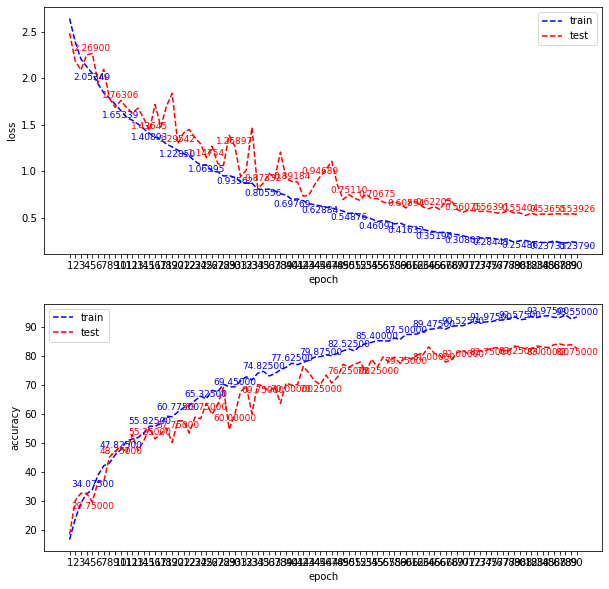

In [13]:
#visualize metric
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

x = [i for i in range(1, epochs+1)]

ax1.plot(x, train_loss_list, 'b--')
ax1.plot(x, test_loss_list, 'r--')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend(['train', 'test'])
ax1.set_xticks(x)
for i, v in enumerate(x):
    if (i+1)%5==0: ax1.text(v, train_loss_list[i], "{:0.5f}".format(train_loss_list[i]), fontsize = 9, color='blue', horizontalalignment='center', verticalalignment='top')
for i, v in enumerate(x):
    if (i+1)%5==0: ax1.text(v, test_loss_list[i], "{:0.5f}".format(test_loss_list[i]), fontsize = 9, color='red', horizontalalignment='center', verticalalignment='bottom')


ax2.plot(x, train_acc_list, 'b--')
ax2.plot(x, test_acc_list, 'r--')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend(['train', 'test'])
ax2.set_xticks(x)
for i, v in enumerate(x):
    if (i+1)%5==0: ax2.text(v, train_acc_list[i], "{:0.5f}".format(train_acc_list[i]), fontsize = 9, color='blue', horizontalalignment='center', verticalalignment='bottom')
for i, v in enumerate(x):
    if (i+1)%5==0: ax2.text(v, test_acc_list[i], "{:0.5f}".format(test_acc_list[i]), fontsize = 9, color='red', horizontalalignment='center', verticalalignment='top')

plt.show()